In [60]:
from time import time
import matplotlib.pyplot as plt
from sksparse.cholmod import cholesky
import scipy
import numpy as np

In [61]:
#nside = 32
#npix =12*nside**2

#matrix_path = '../../PDM/codes/03.FEM_laplacian/HEALPix/'

#A = scipy.sparse.load_npz(matrix_path+'10_matrices/stiffness_matrix_{}.npz'.format(nside))
#B = scipy.sparse.load_npz(matrix_path+'10_matrices/mass_matrix_{}.npz'.format(nside))

nside = 4
A = scipy.sparse.load_npz('matrices/{}_stiffness.npz'.format(nside))
B = scipy.sparse.load_npz('matrices/{}_mass.npz'.format(nside))
npix = A.shape[0]

# 1) Sparse Cholesky Decomposition

### 1.1) Measuring the time to decompose the matrix B

In [62]:
t = time()
factor = cholesky(B)
print("Seconds to perform a sparse Cholesky decomposition = ", time()-t)

Seconds to perform a sparse Cholesky decomposition =  0.0018770694732666016


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  


Let's visualize the result of the sparse Cholesky decomposition:

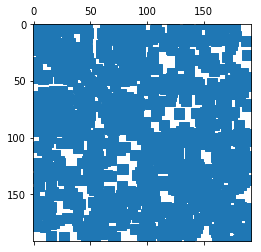

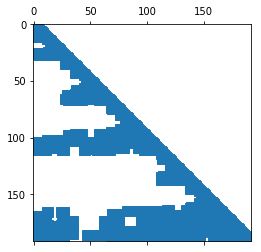

In [63]:
plt.spy(A)
plt.show()
plt.spy(factor.L())

scipy.sparse.save_npz('matrices/{}_cholB'.format(nside), factor.L())

### 1.2) Measuring the time to solve the two sparse triangular systems

In [64]:
b = np.ones(npix)
t = time()
x0 = factor.solve_A(A@b)
print(time()-t)

0.00018596649169921875


# 2) Naive solution of the system

In [65]:
B_array = B.toarray()
A_array = A.toarray()
t = time()
x1 = np.linalg.solve(B_array,A_array@b)
naive_time = time()-t
print(naive_time)

0.0014405250549316406


The solutions obtained with the two methods are actually almost the same:

In [66]:
np.linalg.norm(x0-x1)

1.402163028864468e-13

# 3) Tensorflow implementation (full Cholesky decomposition)

In [67]:
import tensorflow as tf

In [68]:
RHS = np.random.rand(npix,1) 
t = time()
chol = tf.cholesky(A_array)  # shape 10 x 2 x 2
print(time()-t)

0.002627134323120117


In [69]:
t = time()
X = tf.cholesky_solve(chol, RHS)
print(time()-t)
# tf.matmul(A, X) ~ RHS
X  # Solution to the linear system A x = RHS

0.0038115978240966797


<tf.Tensor 'cholesky_solve_16/MatrixTriangularSolve_1:0' shape=(192, 1) dtype=float64>

4 0.0005931854248046875
4 0.004380226135253906
8 0.024821758270263672
8 0.008768320083618164
16 0.895305871963501
16 0.26590657234191895


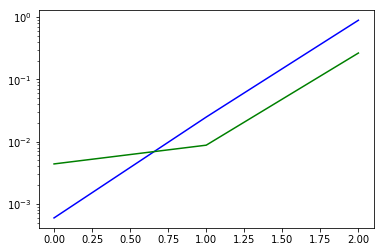

In [77]:
naive_line = []
tf_line = []
nsides = [4,8,16]

for nside in nsides:
    A = scipy.sparse.load_npz('matrices/{}_stiffness.npz'.format(nside))
    B = scipy.sparse.load_npz('matrices/{}_mass.npz'.format(nside))
    cholB = scipy.sparse.load_npz('matrices/{}_cholB.npz'.format(nside))
    npix = A.shape[0]
    
    # naive solve
    b = np.ones(npix)
    B_array = B.toarray()
    A_array = A.toarray()
    RHS = A_array@b
    t = time()
    x1 = np.linalg.solve(B_array,RHS)
    naive_time = time()-t
    naive_line.append(naive_time)
    print(nside, naive_time)
    
    # tensorflow cholesky_solve
    cholB_array = cholB.toarray()
    RHS = np.random.rand(npix,1)
    t = time()
    X = tf.cholesky_solve(cholB_array, RHS)
    tf_time = time()-t
    tf_line.append(tf_time)
    print(nside, tf_time)

plt.plot(naive_line, 'b')
plt.plot(tf_line, 'g')
plt.yscale('log')
plt.show()